# Time Series Decomposition

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set figure size to (12, 6)
plt.rcParams['figure.figsize'] = (12,6)

In [2]:
# Load the flights dataset from seaborn
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


In [3]:
df.month.astype(str) + '-' + df.year.astype(str)

0        January-1949
1       February-1949
2          March-1949
3          April-1949
4            May-1949
            ...      
139       August-1960
140    September-1960
141      October-1960
142     November-1960
143     December-1960
Length: 144, dtype: object

In [4]:
df['Date'] = pd.to_datetime(df.month.astype(str) + '-' + df.year.astype(str))
df.set_index('Date', inplace=True)
df.head()

,year,month,passengers
Date,,,
1949-01-01,1949,January,112
1949-02-01,1949,February,118
1949-03-01,1949,March,132
1949-04-01,1949,April,129
1949-05-01,1949,May,121


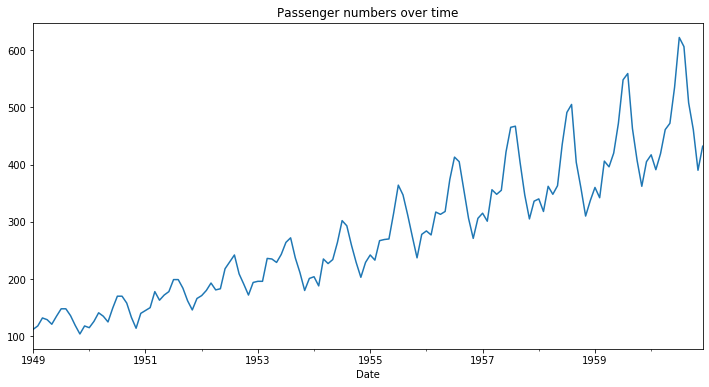

In [5]:
df.passengers.plot(figsize=(12,6), title='Passenger numbers over time')
plt.show()

## 1) Remove the trend

- Differencing - if the trend is linear
- Second order differencing - if the trend is exponential

### 1.1) Differencing

In [6]:
df['difference'] = df['passengers'].diff()
df.head()

,year,month,passengers,difference
Date,,,,
1949-01-01,1949,January,112,NaN
1949-02-01,1949,February,118,6.0
1949-03-01,1949,March,132,14.0
1949-04-01,1949,April,129,-3.0
1949-05-01,1949,May,121,-8.0


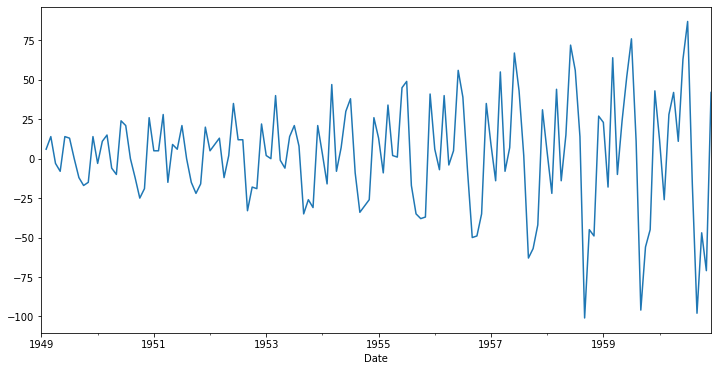

In [8]:
df['difference'].plot()

In [10]:
df['difference'].mean()

2.237762237762238

### 1.2) Second order differencing

Second order differencing is used if the time series has an exponential trend rather than a linear trend.

In [11]:
df['2nddifference'] = df['difference'].diff()
df.head()

,year,month,passengers,difference,2nddifference
Date,,,,,
1949-01-01,1949,January,112,NaN,NaN
1949-02-01,1949,February,118,6.0,NaN
1949-03-01,1949,March,132,14.0,8.0
1949-04-01,1949,April,129,-3.0,-17.0
1949-05-01,1949,May,121,-8.0,-5.0


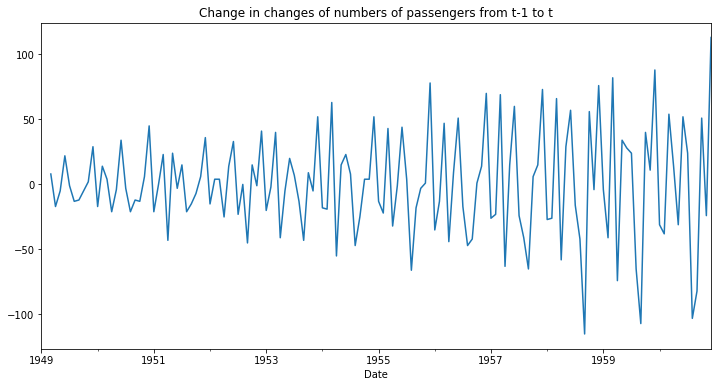

In [12]:
df['2nddifference'].plot(figsize=(12,6), title='Change in changes of numbers of passengers from t-1 to t')

In [14]:
df['2nddifference'].mean()

0.2535211267605634

## All of the resulting time series show an increase in volatility - get rid of it

In [15]:
# Use a log transformation
df['log_passengers'] = np.log(df['passengers'])
df.head()

,year,month,passengers,difference,2nddifference,log_passengers
Date,,,,,,
1949-01-01,1949,January,112,NaN,NaN,4.718499
1949-02-01,1949,February,118,6.0,NaN,4.770685
1949-03-01,1949,March,132,14.0,8.0,4.882802
1949-04-01,1949,April,129,-3.0,-17.0,4.859812
1949-05-01,1949,May,121,-8.0,-5.0,4.795791


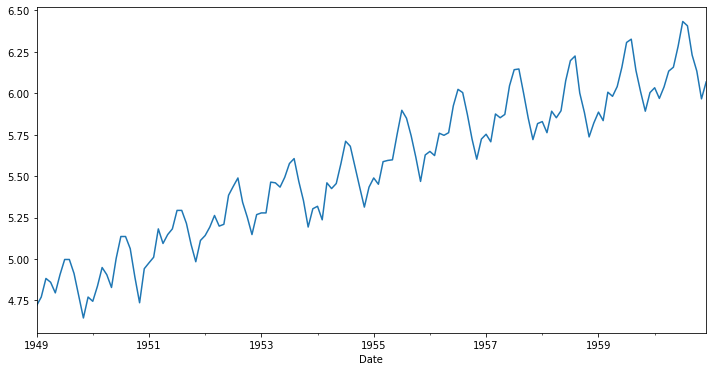

In [16]:
df['log_passengers'].plot(figsize=(12,6))

In [17]:
# Difference the log-transformed time series
df['log_difference'] = df['log_passengers'].diff()

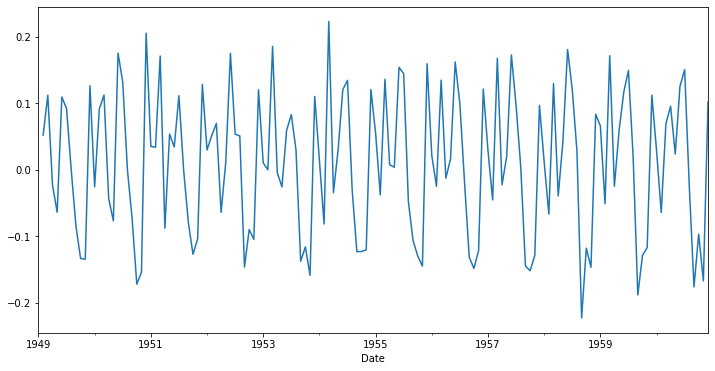

In [18]:
df['log_difference'].plot()

### Take out seasonality

Demean each value by subtracting the monthly mean

In [20]:
# Calculate the monthly mean difference for log_difference
df.groupby('month')['log_difference'].mean()

month
January      0.025154
February    -0.011986
March        0.140296
April       -0.021200
May          0.007696
June         0.132215
July         0.114011
August       0.000774
September   -0.134566
October     -0.128089
November    -0.133649
December     0.123934
Name: log_difference, dtype: float64

In [21]:
# transform takes in a pd series and returns an array of the same length
df['monthly_mean'] = df.groupby('month')['log_difference'].transform('mean')
df.head()

,year,month,passengers,difference,2nddifference,log_passengers,log_difference,monthly_mean
Date,,,,,,,,
1949-01-01,1949,January,112,NaN,NaN,4.718499,NaN,0.025154
1949-02-01,1949,February,118,6.0,NaN,4.770685,0.052186,-0.011986
1949-03-01,1949,March,132,14.0,8.0,4.882802,0.112117,0.140296
1949-04-01,1949,April,129,-3.0,-17.0,4.859812,-0.022990,-0.021200
1949-05-01,1949,May,121,-8.0,-5.0,4.795791,-0.064022,0.007696


In [22]:
# demean the series
df['deseasonalized'] = df['log_difference'] - df['monthly_mean']

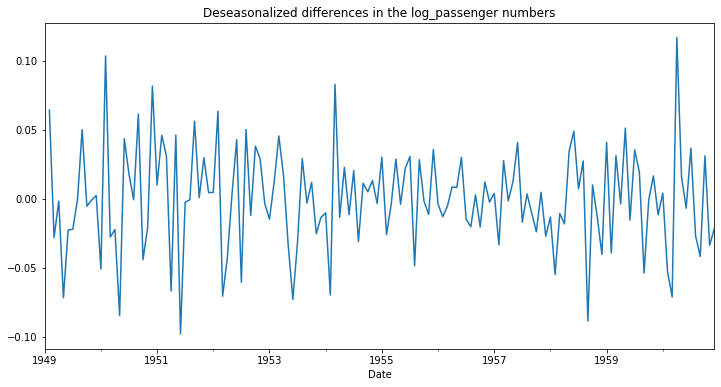

In [23]:
df['deseasonalized'].plot(figsize=(12,6), title='Deseasonalized differences in the log_passenger numbers')

## This is the time series we will actually do our analysis on!

1. We make predictions for the `df['deseasonalized']`
- We add back on the monthly_mean
- We take the first value and create whole log_series
- We exponentiate the values to arrive back at the acutal values

In [33]:
# 2. add back the monthly mean
df['reconstruct'] = df['deseasonalized'] + df['monthly_mean']

In [34]:
# 3. Take the whole series and recreate the whole log series

# 3.1 Take the first value of the series
df.loc[df.index[0], 'reconstruct'] = df.loc[df.index[0], 'log_passengers']

In [35]:
df['reconstruct']

Date
1949-01-01    4.718499
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
                ...   
1960-08-01   -0.026060
1960-09-01   -0.176399
1960-10-01   -0.097083
1960-11-01   -0.167251
1960-12-01    0.102279
Name: reconstruct, Length: 144, dtype: float64

In [36]:
# 3.2 Add the differences cumulatively
df['reconstruct'] = np.cumsum(df['reconstruct'])
df['reconstruct']

Date
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
                ...   
1960-08-01    6.406880
1960-09-01    6.230481
1960-10-01    6.133398
1960-11-01    5.966147
1960-12-01    6.068426
Name: reconstruct, Length: 144, dtype: float64

In [37]:
# 4. Reverse the log transform by taking e to the power of the values
df['reconstruct'] = np.exp(df['reconstruct'])

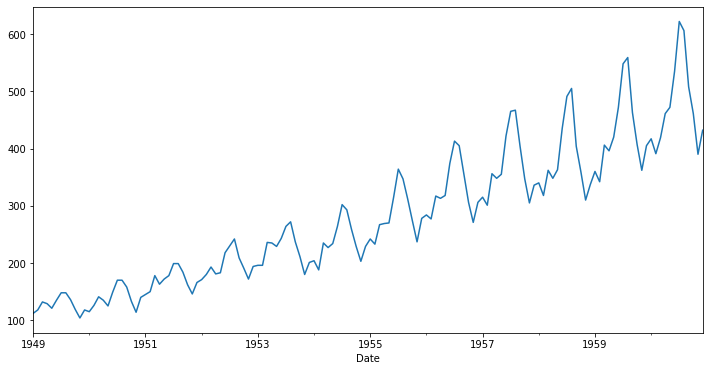

In [38]:
df['reconstruct'].plot()